<a href="https://colab.research.google.com/github/SylwiaNowakowska/Convolutional_Neural_Networks_Ophthalmology/blob/master/02_Transfer_Learning_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pathological Myopia Recognition with DenseNet121 with transfer learning

In this notebook transfer learning approach is applied on the DenseNet121 model for recogntion of pathological myopia from fundus photographs. <br>
The notebook contains also evaluation of the predicted results.

## Imports and parameters setting

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

from sklearn.utils import class_weight
from sklearn.metrics import *

plt.rcParams.update({'font.size': 12})

In [ ]:
# INPUT, OUTPUT PATHS
images_folder_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/Convolutional_Neural_Networks_Ophthalmology/DATASET/preprocessed_images'
project_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/Convolutional_Neural_Networks_Ophthalmology'
output_path = '/content/drive/MyDrive/COLAB_NOTEBOOKS/Convolutional_Neural_Networks_Ophthalmology_ouput'

# DATA PROPERTIES
IMG_SIZE = (512, 512)

# MODEL
model_name = 'CNN_model_3'
transfer_layer ='conv5_block16_1_conv'
transfer_layer_idx = 420
layer_neurons = [512, 256, 128, 64, 32]
dropout = 0.2

# AUGMENTATION
zoom_range=0.05
rotation_range=0.05 
width_shift_range=0.05
height_shift_range=0.05
horizontal_flip=True

# TRAINING
random_state = 16
class_weights = True
EPOCHS = 100
learning_rate = 0.0001
BATCH_SIZE = 32
patience = 10

## Dataframes Loading

In [ ]:
train_df = pd.read_csv(os.path.join(project_path, 'myopia_train_df.csv'), index_col=0)
valid_df = pd.read_csv(os.path.join(project_path, 'myopia_valid_df.csv'), index_col=0)
test_df = pd.read_csv(os.path.join(project_path, 'myopia_test_df.csv'), index_col=0)
train_df.head()

,ID,Patient Age,Patient Sex,filename,labels_descriptive,Slice_idx,binary_label
0,1,57,Male,1_right.jpg,Normal,1,0
1,10,70,Male,10_right.jpg,Normal,3,0
2,13,60,Female,13_right.jpg,Pathological Myopia,4,1
3,18,58,Male,18_right.jpg,Pathological Myopia,6,1
4,29,59,Male,29_right.jpg,Normal,7,0


## Data Generators

In [ ]:
def get_image_generators(zoom_range=0.1, rotation_range=0.1, width_shift_range=0.1,
                        height_shift_range=0.1, horizontal_flip=True):

    train_image_gen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=zoom_range,
        rotation_range=rotation_range,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range,
        horizontal_flip=horizontal_flip)
    
    valid_image_gen = ImageDataGenerator(
        rescale=1./255.)
    
    test_image_gen = ImageDataGenerator(
        rescale=1./255.)
    
    return train_image_gen, valid_image_gen, test_image_gen


def get_generators(train_image_gen, valid_image_gen, test_image_gen, 
                   train_df, valid_df, test_df, 
                   directory, x_col, y_col,
                   target_size, class_mode, batch_size=32, seed=42):

    train_generator = train_image_gen.flow_from_dataframe(
        train_df,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        color_mode='rgb',
        class_mode=class_mode,
        batch_size=batch_size,
        shuffle=True,
        seed=seed)
    
    valid_generator = valid_image_gen.flow_from_dataframe(
        valid_df,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        color_mode='rgb',
        class_mode=class_mode,
        batch_size=batch_size,
        shuffle=False,
        seed=seed)
    
    test_generator = test_image_gen.flow_from_dataframe(
        test_df,
        directory=directory,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        color_mode='rgb',
        class_mode=class_mode,
        batch_size=batch_size,
        shuffle=False,
        seed=seed)
    
    return train_generator, valid_generator, test_generator

def validate_generator(generator):
    images, labels = generator[0]
    fig, axs = plt.subplots(1, 5, figsize=(20,10))
    for i in range(5):
        axs[i].imshow(images[i])
        axs[i].set_title(labels[i])
        axs[i].axis('off')
    plt.show()

In [ ]:
train_image_gen, valid_image_gen, test_image_gen = get_image_generators(zoom_range=zoom_range, 
                                                                        rotation_range=rotation_range, 
                                                                        width_shift_range=width_shift_range,
                                                                        height_shift_range=height_shift_range, 
                                                                        horizontal_flip=horizontal_flip)

train_gen, valid_gen, test_gen  = get_generators(train_image_gen, valid_image_gen, test_image_gen, 
                                                 train_df, valid_df, test_df, 
                                                 directory= images_folder_path,
                                                 x_col='filename',
                                                 y_col='labels_descriptive',
                                                 target_size=IMG_SIZE,
                                                 class_mode='binary',
                                                 batch_size=BATCH_SIZE,
                                                 seed=random_state)

print(train_gen.class_indices)

/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 6 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  n_invalid, x_col))
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 7 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  n_invalid, x_col))


Found 1873 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.
Found 615 validated image filenames belonging to 2 classes.
{'Normal': 0, 'Pathological\xa0Myopia': 1}


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 4 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  n_invalid, x_col))


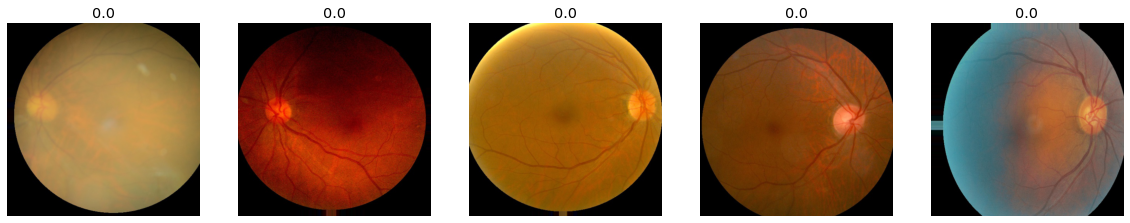

In [ ]:
validate_generator(train_gen)

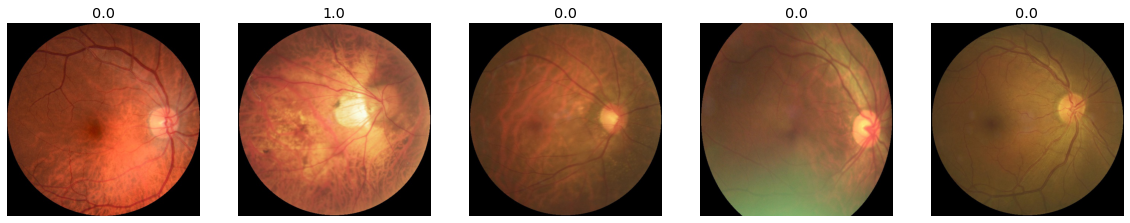

In [ ]:
validate_generator(valid_gen)

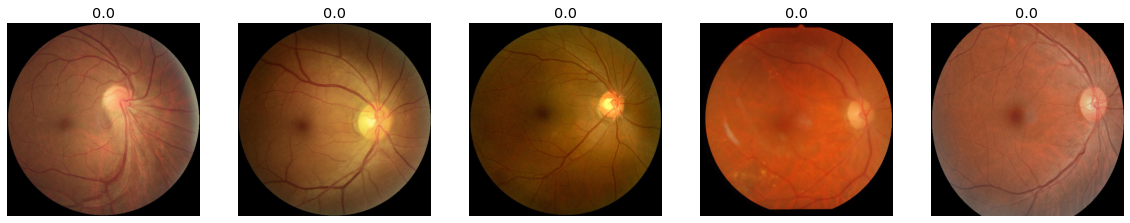

In [ ]:
validate_generator(test_gen)

In [ ]:
# Due to the class imbalance, the loss function will be weighted accordingly.
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_gen.labels), y=train_gen.labels) 
class_weights = dict(zip(np.unique(train_gen.labels), class_weights))
class_weights

{0: 0.5394585253456221, 1: 6.835766423357664}

## Model Training

### Functions for training

In [ ]:
def load_pretrained_model(pretrained_model, transfer_layer, transfer_layer_idx, 
                          weights='imagenet', verbose=False):
    
    """
    Return pre-trained model with defined weights and defined transfer layer.
    
    Args:
        pretrained model (Model): the pretrained model.
        transfer_layer (str): name of the layer from which the weights will be learned during training.
        transfer_layer_idx (int): index of the previously specified transfer layer.
        weights (str): weights, which will be loaded.
        verbose (bool): if True, the trainability atribute will be printed for each layer.
        
    Returns:
        pretrained model (Model): the pretrained model. 
    """
    
    model = pretrained_model(include_top=True, weights=weights)
    transfer_layer = model.get_layer(transfer_layer)
    pretrained_model = Model(inputs = model.input, outputs = model.output) 
    
    # freezing layers till transfer_layer
    for layer in pretrained_model.layers[0:transfer_layer_idx]:
        layer.trainable = False
    
    # rechecking, if the freezeing was performed correctly
    if verbose == True:
        print('Pre-trained model layers and their trainability')
        for layer in pretrained_model.layers:
            print(layer.name, layer.trainable)
        
    return pretrained_model


def build_model(pretrained_model, layer_neurons=[512, 256, 128, 64, 32],  dropout=0.2):
    
    """
    Function builing a model by attaching layers after the pre-trained model.
    
    Args:
        pretrained model (Model): the pretrained model.
        layer_neurons (list of int): specifies the number of layers to be added to 
                                     the pretrained model and the number of neurons in each.
        dropout (Float): fraction of neurons randomly swiching off during training.
    
    Returns:
    model (Model): final model
    """
    
    model = Sequential()
    model.add(pretrained_model)

    for neurons in layer_neurons:
        model.add(Dense(neurons, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='sigmoid'))
        
    return model

In [ ]:
def model_compile(model, learning_rate, optimizer="Adam", loss="binary_crossentropy"):
    
    if optimizer == "Adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "Adamax":
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    elif optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        print("Optimizer not found!")

    metrics = metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), 
                       tf.keras.metrics.FalseNegatives(name="FN"), 
                       tf.keras.metrics.FalsePositives(name="FP")]
    
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return model


def train_model(model, model_name, project_folder_path, train_generator, valid_generator, epochs=100, 
                                   class_weights=True, monitor='val_loss', mode='min', patience=15):
    
    # Folder for saving all the data
    model_folder = os.path.join(project_folder_path, model_name)
    if not os.path.exists(model_folder):
        os.makedirs(model_folder)
    
    # Set callbacks
    checkpoint_path = os.path.join(model_folder, "checkpoint_model.h5")

    checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor = monitor, 
                             verbose = 1, 
                             save_best_only = True, 
                             mode = mode, 
                             save_weights_only = False)
    
    
    early = EarlyStopping(monitor = monitor, 
                      mode = mode, 
                      patience=patience,
                      restore_best_weights=True)
    
    nan_termination = TerminateOnNaN()
    callbacks_list = [checkpoint, early, nan_termination]
    
    # Model training
    if class_weights:
        class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(train_gen.labels), y=train_gen.labels) 
        class_weights = dict(zip(np.unique(train_gen.labels), class_weights))

        history = model.fit(train_generator, 
                            validation_data = valid_generator,
                            epochs = epochs,
                            class_weight = class_weights,
                            callbacks = callbacks_list)
    else:
        history = model.fit(train_generator, 
                            validation_data = valid_generator,
                            epochs = epochs,
                            callbacks = callbacks_list)
    
    # Training history: plotting and saving
    history_df = pd.DataFrame(history.history)
    plot_history(history_df, fig_output_path=os.path.join(model_folder, "history.tiff"))
    history_df.to_csv(os.path.join(model_folder, "history.csv"))
    
    return history


def plot_history(history_df, fig_output_path=None):   
    # Extract checkpoint info
    checkpoint_epoch = history_df["val_loss"].argmin()
    checkpoint_val_loss = history_df["val_loss"].min()
    checkpoint_info = f'checkpoint: {checkpoint_epoch + 1} epoch, val_loss {checkpoint_val_loss:.2f}'

    # Determine what signals to plot together and how many plots there should be
    training_curves = history_df.columns.tolist()
    
    to_plot = []
    for signal in training_curves:
        signal_curves = [j for j in training_curves if signal in j]
        training_curves = list(set(training_curves) - set(signal_curves))
        if len(signal_curves) != 0:
            to_plot.append(sorted(signal_curves))
     
    # Plotting
    plt.rcParams.update({'font.size': 14})
    rows = math.ceil(len(to_plot) / 2) 
    fig, axs = plt.subplots(rows,2, figsize=(25,10))
    axs = axs.flatten()
    N = len(history_df)
    
    for ax, signals in zip(axs, to_plot):
        for signal in signals:
            ax.plot(np.arange(1, N+1), history_df[signal], label=signal, linewidth=3.0)
            
            if signal == "loss":
                ax.axvline(x=checkpoint_epoch+1, linestyle="--", color="black", label=checkpoint_info)
    
        ax.set_xlabel("# of epoch")
        ax.set_ylabel(signals[0])
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()
        
        subplots_number = rows * 2

    if subplots_number > len(to_plot):
        for i in range(len(to_plot), subplots_number):
            axs[i].axis('off')
    
    
    fig.tight_layout(pad=3.0)
    
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    
    plt.show()


### Model building and training

In [ ]:
# Build model
model_pretrained = load_pretrained_model(pretrained_model=DenseNet121, 
                                         transfer_layer=transfer_layer, 
                                         transfer_layer_idx=transfer_layer_idx, 
                                         verbose=False)

model = build_model(model_pretrained, layer_neurons=layer_neurons, dropout=dropout)
model = model_compile(model, learning_rate=learning_rate, loss='binary_crossentropy')

# Print info about the model parameters
trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 8,753,577
Trainable params: 1,880,233
Non-trainable params: 6,873,344


Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 0.6620 - acc: 0.5782 - FN: 27.0000 - FP: 763.0000
Epoch 1: val_loss improved from inf to 0.59640, saving model to /content/drive/MyDrive/COLAB_NOTEBOOKS/Convolutional_Neural_Networks_Ophthalmology_ouput/CNN_model_3/checkpoint_model.h5
59/59 [==============================] - 173s 3s/step - loss: 0.6620 - acc: 0.5782 - FN: 27.0000 - FP: 763.0000 - val_loss: 0.5964 - val_acc: 0.9150 - val_FN: 51.0000 - val_FP: 0.0000e+00
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 0.4855 - acc: 0.6268 - FN: 8.0000 - FP: 691.0000
Epoch 2: val_loss improved from 0.59640 to 0.50456, saving model to /content/drive/MyDrive/COLAB_NOTEBOOKS/Convolutional_Neural_Networks_Ophthalmology_ouput/CNN_model_3/checkpoint_model.h5
59/59 [==============================] - 113s 2s/step - loss: 0.4855 - acc: 0.6268 - FN: 8.0000 - FP: 691.0000 - val_loss: 0.5046 - val_acc: 0.9150 - val_FN: 51.0000 - val_FP: 0.0000e+00
Epoch 3/100
59

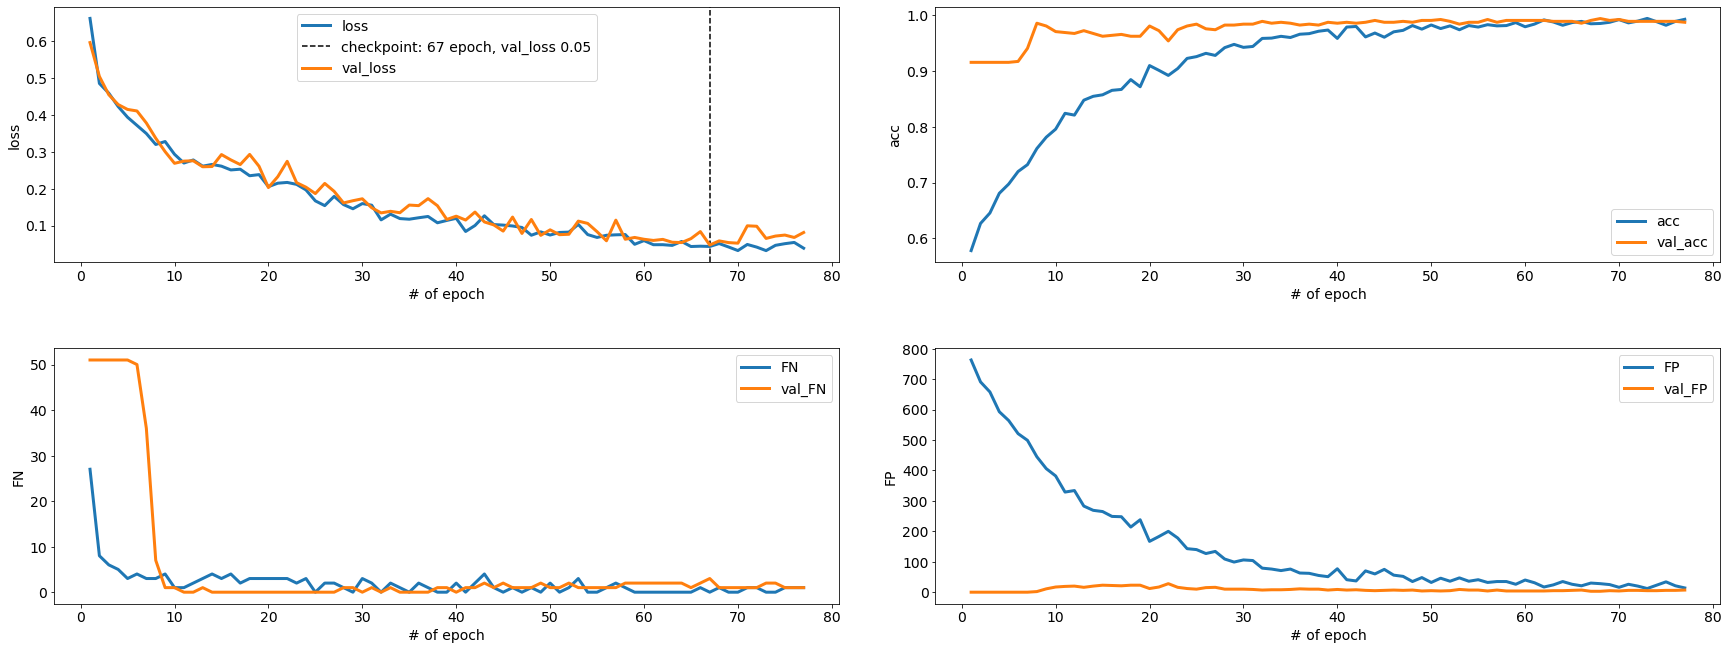

In [ ]:
# Train the model
history = train_model(model, model_name, output_path, train_gen, valid_gen, epochs=EPOCHS, monitor='val_loss', mode='min', patience=patience)

## Loading trained model

In [ ]:
model_folder_path = os.path.join(output_path, model_name)
model_path = os.path.join(model_folder_path, "checkpoint_model.h5")
model = load_model(model_path)
print(f"Loaded model: {model_path}")

Loaded model: /content/drive/MyDrive/COLAB_NOTEBOOKS/Convolutional_Neural_Networks_Ophthalmology_ouput/CNN_model_3/checkpoint_model.h5


## Predicting

In [ ]:
def predict(model, test_gen, steps,  output_path=None):
    y_pred = model.predict(test_gen, steps=steps, verbose = True)

    prediction_df = pd.DataFrame()
    prediction_df['filenames'] = test_gen.filenames
    prediction_df['y_true'] = test_gen.labels
    prediction_df['y_pred'] = y_pred

    if output_path:
        prediction_df.to_csv(output_path)

    return prediction_df

In [ ]:
predictions_output_path = os.path.join(output_path, model_name, 'prediction_df.csv')
prediction_df = predict(model, test_gen, steps=len(test_df)/BATCH_SIZE,  output_path=predictions_output_path)

19/19 [==============================] - 21s 1s/step


## Evaluating

### Functions for evaluation

In [ ]:
def plot_prediction_distribution(pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    plt.hist(pred_array, bins=50)
    plt.title('Distribution of model predictions')
    plt.xlabel('Probability')
    plt.ylabel('# number of images')
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()
    print(f'Model prediction min: {pred_array.min():.3}')
    print(f'Model prediction max: {pred_array.max():.3}')
    

def plot_AUROC(GT_array, pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    fpr, tpr, thresholds = roc_curve(GT_array, pred_array)
    plt.plot(fpr, tpr, label = '%s (AUC: %0.2f)'  % ('Model', auc(fpr, tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Random choice')
    plt.legend()
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()
    

def plot_precision_recall_curve(GT_array, pred_array, fig_output_path=None):

    plt.figure(figsize=(6,4))
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    plt.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Model', average_precision_score(GT_array,pred_array)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)


def plot_f1_tresh(GT_array, pred_array, fig_output_path=None):
    precision, recall, thresholds = precision_recall_curve(GT_array, pred_array)
    f1 = calc_f1(precision, recall)
    plt.figure(figsize=(6,4))
    plt.plot(f1[:-1], thresholds)
    plt.xlabel('F1 score')
    plt.ylabel('Treshold')
    plt.tight_layout(pad=1.0)
    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white")
    plt.show()


def plot_confusion_matrix(cf_matrix, classes, title=None, fig_output_path=None):
    cf_matrix = cf_matrix.round(decimals=2)

    fig, axs = plt.subplots(1, 1, figsize=(6,6))
    plt.rcParams.update({'font.size': 20})

    if title:
        fig.suptitle(title, fontsize=20, y = 1, x = 0.52)
    
    sns.heatmap(cf_matrix, xticklabels=classes, yticklabels=classes, annot=True, 
                fmt=".0%", cbar=False, square=True, ax=axs, cmap="Blues")
    axs.set_xlabel("Predicted labels", fontsize=20)
    axs.set_ylabel("True labels",fontsize=20)
    fig.tight_layout(pad=1.0)

    if fig_output_path:
        plt.savefig(fig_output_path, dpi=100, pad_inches=1, facecolor="white") 
    plt.show()
    

def evaluate(GT_array, pred_array, output_folder_path=None):
    if output_folder_path:
        prediction_distribution_output = os.path.join(output_folder_path, 'prediction_distribution.tiff')
        AUROC_output = os.path.join(output_folder_path, 'AUROC.tiff')
        precision_recall_output = os.path.join(output_folder_path, 'precision_recall.tiff')
        t1_tresh_output = os.path.join(output_folder_path, 't1_tresh.tiff')

    else:
        prediction_distribution_output = None
        AUROC_output = None
        precision_recall_output = None
        t1_tresh_output= None

    plot_prediction_distribution(pred_array, fig_output_path=prediction_distribution_output)
    plot_AUROC(GT_array, pred_array, fig_output_path=AUROC_output)
    plot_precision_recall_curve(GT_array, pred_array, fig_output_path=precision_recall_output)
    plot_f1_tresh(GT_array, pred_array, fig_output_path=t1_tresh_output)


def evaluate_treshold(prediction_df, threshold, classes, output_folder_path=None):
    evaluation_df = prediction_df.copy()
    column_name = "treshold_" + str(threshold)
    conditions = [evaluation_df['y_pred'] >= threshold,
                 evaluation_df['y_pred'] < threshold]

    values = [1, 0]
    evaluation_df[column_name] = np.select(conditions, values)

    acc = accuracy_score(evaluation_df['y_true'], evaluation_df[column_name])
    cf_matrix = confusion_matrix(evaluation_df['y_true'], evaluation_df[column_name], normalize="true") 
    cf_title = "Acc = " + str(round(acc,2))

    if output_path:
        evaluation_df.to_csv(os.path.join(output_folder_path, 'evaluation_df.csv'))
        cf_matrix_output_path = os.path.join(output_folder_path, 'cf_matrix.tiff')
        plot_confusion_matrix(cf_matrix, classes=classes, title=cf_title, fig_output_path=cf_matrix_output_path)
    else:
        plot_confusion_matrix(cf_matrix, classes=classes, title=cf_title, fig_output_path=None)

    return evaluation_df

### Evaluation

In [ ]:
# Load predictions
predictions_output_path = os.path.join(output_path, model_name, 'prediction_df.csv')
preduction_df = pd.read_csv(predictions_output_path, index_col=0)
preduction_df.head()

,filenames,y_true,y_pred
0,37_right.jpg,0,0.034976
1,61_right.jpg,0,0.028032
2,73_right.jpg,0,0.021483
3,78_right.jpg,0,0.027891
4,84_right.jpg,0,0.026759


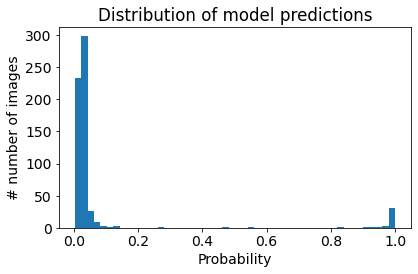

Model prediction min: 0.00266
Model prediction max: 1.0


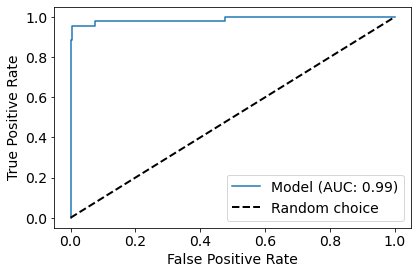

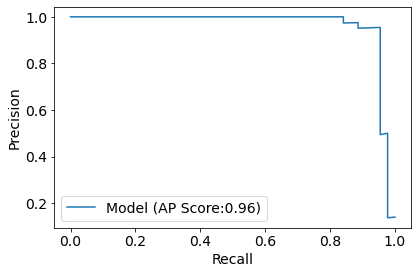

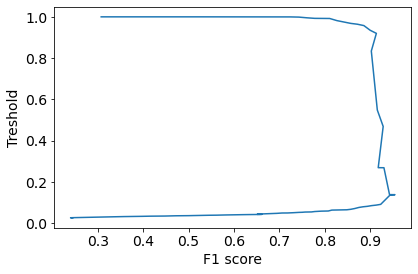

In [ ]:
# Evaluate
evaluation_output_path = os.path.join(output_path, model_name)

y_true = preduction_df['y_true'].to_numpy()
y_pred = preduction_df['y_pred'].to_numpy()

evaluate(y_true, y_pred, evaluation_output_path)

In [ ]:
# Choose treshold
THRESHOLD = 0.2

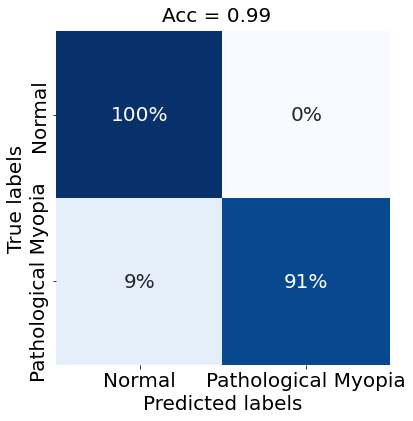

In [ ]:
evaluation_df = evaluate_treshold(prediction_df, threshold=THRESHOLD, classes=['Normal', 'Pathological Myopia'], output_folder_path=evaluation_output_path)

In [ ]:
# Investigating misclassified images
evaluation_output_path = os.path.join(output_path, model_name, 'evaluation_df.csv')
evaluation_df = pd.read_csv(evaluation_output_path, index_col=0)
misclassified_df = evaluation_df[evaluation_df['y_true'] != evaluation_df['treshold_0.2']]
misclassified_df = misclassified_df.reset_index(drop=True)
misclassified_df

,filenames,y_true,y_pred,treshold_0.2
0,475_right.jpg,1,0.041795,0
1,1519_right.jpg,1,0.025175,0
2,1520_right.jpg,1,0.137118,0
3,831_left.jpg,1,0.137517,0
4,2470_left.jpg,0,0.268190,1
5,3138_left.jpg,0,0.834065,1


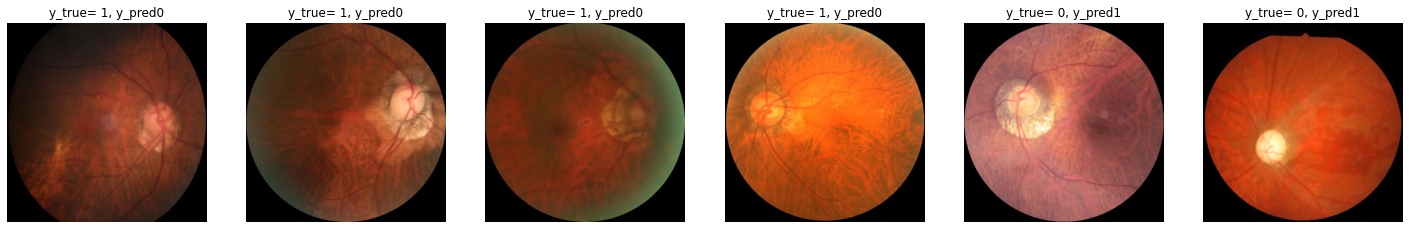

In [ ]:
fig, axs = plt.subplots(1, 6, figsize=(25, 5))
axs = axs.flatten()

for i, image in enumerate(misclassified_df['filenames'].tolist()):
    image_path = os.path.join(images_folder_path, image)
    image_array = plt.imread(image_path)
    y_true = misclassified_df.loc[i, 'y_true']
    y_pred = misclassified_df.loc[i, 'treshold_0.2']
    title = 'y_true= ' + str(y_true) + ', y_pred' + str(y_pred)
    axs[i].imshow(image_array)
    axs[i].axis('off')
    axs[i].set_title(title, fontsize=12)
plt.show()
